# Cuisine Classification based on Recipe Ingredients

## Table of Contents
* Preprocessing
* Idea 1: Bag of Words + Logistic Regression
* Feature Selection
  + Variance Threshold (unhelpful)
  + Mutual Information (unhelpful)
  + Chi2 (unhelpful)
  + Lasso Logistic Regression (helpful)
* Analyze the Weakness of Bag of Words + Logistic Regression
* Idea 2: Random Forest with Bag of Words and Logistic Regression Results as Features
* Idea 3: Random Forest for Confused Cuisine Pairs
  + French vs Italian
  + Modify Logistic Regression Predictions with French vs Italian Classifier
  + Random Forest for each Confused Cuisine Pair
  
### Test Scores (Accuracy)
* Bag of Words + Random Forest: 0.679
* Idea 1 Bag of Words + Logistic Regression: 0.777
* Idea 2: 0.789
* Idea 3: 0.782

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, chi2, mutual_info_classif, SelectPercentile, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import SparsePCA
from scipy.sparse import hstack
from scipy.sparse.csr import csr_matrix

/Users/ChingYunH/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
traindata = pd.io.json.read_json('train.json')
testdata = pd.io.json.read_json('test.json')

In [3]:
testdata = pd.io.json.read_json('test.json')

In [4]:
traindata.count()

cuisine        32897
id             32897
ingredients    32897
dtype: int64

Split data into training set and validation set.

In [5]:
train, cv = train_test_split(traindata, train_size=0.8)

In [6]:
train.groupby('cuisine').count()['id'].sort_values(ascending=False)

cuisine
italian         5170
mexican         4240
southern_us     2839
indian          2013
chinese         1813
french          1791
thai            1014
cajun_creole     994
japanese         952
greek            763
spanish          648
british          550
vietnamese       545
moroccan         542
korean           516
filipino         501
irish            458
jamaican         346
russian          324
brazilian        298
Name: id, dtype: int64

# Idea 1: Simple Bag of Words + Logistic Regression

In [7]:
vectorizer = CountVectorizer(preprocessor=lambda x: ','.join(x).lower())
features = vectorizer.fit_transform(train.ingredients)
feature_names = vectorizer.get_feature_names()
cv_features = vectorizer.transform(cv.ingredients)
test_features = vectorizer.transform(testdata.ingredients)

In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(train.cuisine)
labels = label_encoder.transform(train.cuisine)
cv_labels = label_encoder.transform(cv.cuisine)

In [9]:
lr = LogisticRegression()
lr.fit(X=features, y=labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
lr.score(X=cv_features, y=cv_labels)

0.7735562310030395

In [11]:
testdata['cuisine'] = label_encoder.inverse_transform(lr.predict(X=test_features))
testdata[['id','cuisine']].set_index('id').to_csv('submission_logistic_bag.csv')

# Feature Selection

## Variance Threshold (unhelpful)

In [12]:
threshold_p = [0.0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
score = {}
for p in threshold_p:
    selvar = VarianceThreshold(threshold=(p * (1 - p)))
    features_selvar = selvar.fit_transform(features)
    cv_features_selvar = selvar.transform(cv_features)
    lr = LogisticRegression()
    lr.fit(X=features_selvar, y=labels)
    score[p] = lr.score(X=cv_features_selvar, y=cv_labels)

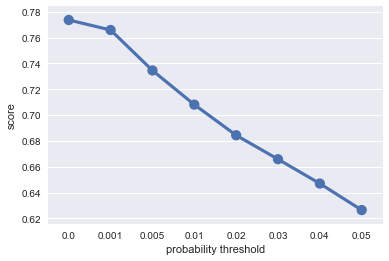

In [13]:
sns.pointplot(x=threshold_p, y=[score[p] for p in threshold_p])
plt.ylabel('score')
plt.xlabel('probability threshold')
plt.show()

Filtering by variance doesn't help. Maybe it's because some rare ingredients are unique to some cuisines.

## Mutual Information (unhelpful)

In [14]:
threshold_p = [10, 25, 50, 75, 90, 95]
score = {}
for p in threshold_p:
    mutualinfo = SelectPercentile(score_func=mutual_info_classif, percentile=p)
    features_mi = mutualinfo.fit_transform(features, labels)
    cv_features_mi = mutualinfo.transform(cv_features)
    lr = LogisticRegression()
    lr.fit(X=features_mi, y=labels)
    score[p] = lr.score(X=cv_features_mi, y=cv_labels)

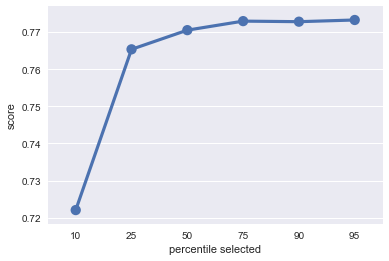

In [15]:
sns.pointplot(x=threshold_p, y=[score[p] for p in threshold_p])
plt.ylabel('score')
plt.xlabel('percentile selected')
plt.show()

Filtering by mutual information doesn't help either. 

## Chi2 Feature Selection (unhelpful)

In [16]:
threshold_p = [10, 25, 50, 75, 90, 95]
score = {}
for p in threshold_p:
    selector = SelectPercentile(score_func=chi2, percentile=p)
    features_ = selector.fit_transform(features, labels)
    cv_features_ = selector.transform(cv_features)
    lr = LogisticRegression()
    lr.fit(X=features_, y=labels)
    score[p] = lr.score(X=cv_features_, y=cv_labels)

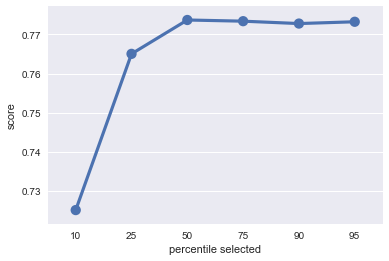

In [17]:
sns.pointplot(x=threshold_p, y=[score[p] for p in threshold_p])
plt.ylabel('score')
plt.xlabel('percentile selected')
plt.show()

Filtering by chi2 doesn't help either. 

## Lasso Logistic Regression Feature Selection (helpful)

In [18]:
lr_lasso = LogisticRegression(penalty='l1').fit(X=features, y=labels)

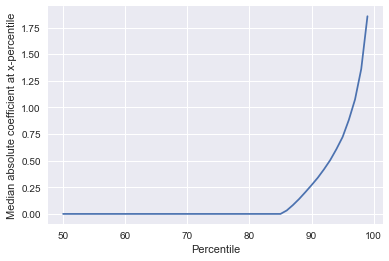

In [19]:
tmp = np.arange(50,100)
plt.plot(tmp, [np.percentile(abs(lr_lasso.coef_), q=x) for x in tmp])
plt.xlabel('Percentile')
plt.ylabel('Median absolute coefficient at x-percentile')
plt.show()

In [20]:
lr_lasso = LogisticRegression(penalty='l1').fit(X=features, y=labels)
selector = SelectFromModel(lr_lasso, prefit=True, threshold=1e-5)
features_ = selector.transform(features)
cv_features_ = selector.transform(cv_features)
lr = LogisticRegression()
lr.fit(X=features_, y=labels)
lr.score(X=cv_features_, y=cv_labels)

0.77234042553191484

In [21]:
1.0 * features_.shape[1] / features.shape[1]

0.5136298421807748

In [22]:
score = {}
for thres in np.exp(np.arange(-5,1)):
    lr_lasso = LogisticRegression(penalty='l1').fit(X=features, y=labels)
    selector = SelectFromModel(lr_lasso, prefit=True, threshold=thres)
    features_ = selector.transform(features)
    cv_features_ = selector.transform(cv_features)
    lr = LogisticRegression()
    lr.fit(X=features_, y=labels)
    score[thres] = lr.score(X=cv_features_, y=cv_labels)

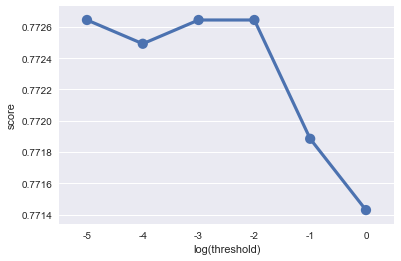

In [23]:
sns.pointplot(x=np.arange(-5,1), y=[score[np.exp(p)] for p in np.arange(-5,1)])
plt.ylabel('score')
plt.xlabel('log(threshold)')
plt.show()

The logistic regression model based feature selection is effective: fewer features but still similar performance. Although it's not a big performance boost.

In [24]:
lr_lasso = LogisticRegression(penalty='l1').fit(X=features, y=labels)
selector = SelectFromModel(lr_lasso, prefit=True, threshold=1e-3)
features_lasso = selector.transform(features)
cv_features_lasso = selector.transform(cv_features)
test_features_lasso = selector.transform(test_features)

In [25]:
num_features_lasso = features_lasso.shape[1]

In [26]:
feature_names_lasso = np.array(feature_names)[selector.inverse_transform(
    np.ones(num_features_lasso)).ravel().astype(bool)]

/Users/ChingYunH/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [27]:
lr = LogisticRegression(penalty='l1').fit(X=features_lasso, y=labels)

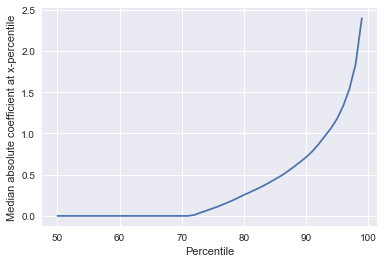

In [28]:
tmp = np.arange(50,100)
plt.plot(tmp, [np.percentile(abs(lr.coef_), q=x) for x in tmp])
plt.xlabel('Percentile')
plt.ylabel('Median absolute coefficient at x-percentile')
plt.show()

In [29]:
lr = LogisticRegression(penalty='l2').fit(X=features_lasso, y=labels)

In [30]:
lr.score(X=cv_features_lasso, y=cv_labels)

0.77264437689969601

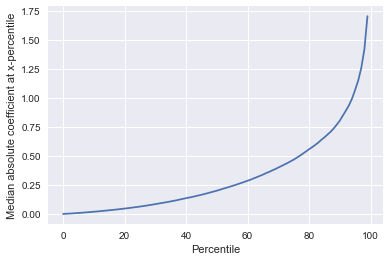

In [31]:
tmp = np.arange(0,100)
plt.plot(tmp, [np.percentile(abs(lr.coef_), q=x) for x in tmp])
plt.xlabel('Percentile')
plt.ylabel('Median absolute coefficient at x-percentile')
plt.show()

# Analyze the Weakness of Bag of Words + Logistic Regression

In [32]:
guess = lr.predict(X=features_lasso)
proba = lr.predict_proba(X=features_lasso)

In [33]:
train_compare = pd.concat([train[['ingredients','cuisine']], pd.Series(index=train.index, 
                                      data=label_encoder.inverse_transform(guess),
                                      name='guess')], axis=1)
train_compare['prob_guess'] = np.max(proba, axis=1)

In [34]:
wrong = train_compare[train_compare['guess'] != train_compare['cuisine']]

In [35]:
(wrong.groupby('cuisine')['cuisine'].count() / train.groupby('cuisine')['cuisine'].count()).sort_values(ascending=False)

cuisine
british         0.403636
spanish         0.393519
russian         0.351852
irish           0.344978
vietnamese      0.326606
brazilian       0.302013
filipino        0.261477
french          0.251815
japanese        0.234244
greek           0.230668
cajun_creole    0.221328
jamaican        0.187861
thai            0.168639
korean          0.164729
southern_us     0.142656
moroccan        0.140221
chinese         0.097077
italian         0.074275
indian          0.055638
mexican         0.050943
Name: cuisine, dtype: float64

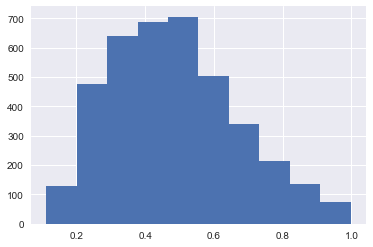

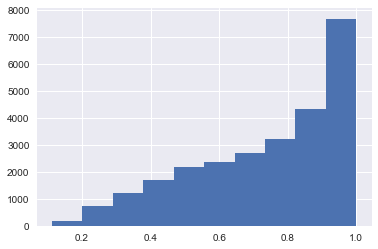

In [36]:
wrong.prob_guess.hist()
plt.show()
train_compare.prob_guess.hist()
plt.show()

In [37]:
wrong_grouped = wrong.groupby(['cuisine', 'guess']).count()['prob_guess'].rename('count').sort_values(ascending=False)

In [38]:
wrong_grouped.head(10)

cuisine       guess       
french        italian         256
italian       french          160
cajun_creole  southern_us     113
greek         italian         106
spanish       italian         101
southern_us   italian          98
french        southern_us      96
italian       southern_us      86
british       southern_us      82
southern_us   cajun_creole     80
Name: count, dtype: int64

Some similar cuisines get mixed up easily. Maybe it would help to use random forest to distinguish the similar cuisines.

In [39]:
G = nx.DiGraph()
G.add_nodes_from(np.unique(wrong.cuisine.values))

In [40]:
G.add_weighted_edges_from([(r[0][0], r[0][1], r[1]) for r in wrong_grouped[wrong_grouped > 50].iteritems()])

/Users/ChingYunH/anaconda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/ChingYunH/anaconda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/ChingYunH/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/ChingYunH/anaconda/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn(

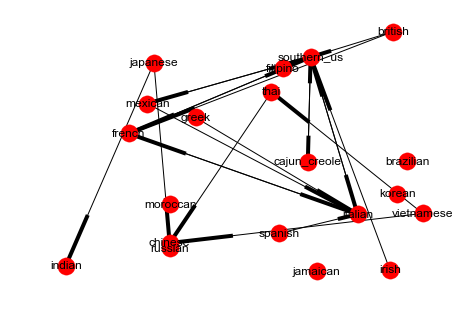

In [41]:
nx.draw_random(G, with_labels=True)
plt.show()

# Idea 2: Bag of Words + Logistic Regression + Random Forest

Add probabilities predicted by logistic regression as features for random forest.

In [42]:
features_plus = hstack((features_lasso, csr_matrix(proba)))
features_plus = csr_matrix(features_plus)

In [43]:
cv_features_plus = hstack((cv_features_lasso, csr_matrix(lr.predict_proba(X=cv_features_lasso))))
cv_features_plus = csr_matrix(cv_features_plus)

In [44]:
test_features_plus = hstack((test_features_lasso, csr_matrix(lr.predict_proba(X=test_features_lasso))))
test_features_plus = csr_matrix(test_features_plus)

## Random Forest on All Cuisine (with logistic regression probabilities as part of features)

In [45]:
forest = RandomForestClassifier(n_estimators = 1000)

In [46]:
forest.fit(X=features_plus, y=labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [47]:
forest.score(X=cv_features_plus, y=cv_labels)

0.78844984802431606

In [48]:
testdata['cuisine'] = label_encoder.inverse_transform(forest.predict(X=test_features_plus))
testdata[['id','cuisine']].set_index('id').to_csv('submission_forest.csv')

# Idea 3: Random Forest for Confused Cuisine Pairs

## French vs Italian

In [49]:
french_italian_ind = (train['cuisine'] == 'french') | (train['cuisine'] == 'italian')
french_italian = train[french_italian_ind]

In [50]:
french_italian_ind_cv = (cv['cuisine'] == 'french') | (cv['cuisine'] == 'italian')

In [51]:
french_italian_forest = RandomForestClassifier(n_estimators = 100)

In [52]:
french_italian_forest.fit(X=features_plus[french_italian_ind.values], y=labels[french_italian_ind.values])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [53]:
cv_french_italian_ind = (cv['cuisine'] == 'french') | (cv['cuisine'] == 'italian')
french_italian_forest.score(X=cv_features_plus[cv_french_italian_ind.values], 
             y=cv_labels[cv_french_italian_ind.values])

0.89942196531791907

In [54]:
lr.score(X=cv_features_lasso[cv_french_italian_ind.values], 
             y=cv_labels[cv_french_italian_ind.values])

0.82716763005780347

Random forest is better than logistic regression at telling two cuisines apart.

## Modify Logistic Regression Predictions with French vs Italian Classifer

In [56]:
cv_prediction = lr.predict(X=cv_features_lasso)

In [57]:
predicted_french_italian = (cv_prediction == label_encoder.transform(['french']).ravel()) | (
    cv_prediction == label_encoder.transform(['italian']).ravel()) 

In [58]:
french_or_italian = french_italian_forest.predict(X=cv_features_plus[predicted_french_italian])

In [59]:
cv_combined_prediction = cv_prediction.copy()
np.put(cv_combined_prediction, np.where(predicted_french_italian)[0], french_or_italian)

In [60]:
french_italian_forest.score(X=cv_features_plus[predicted_french_italian], 
             y=cv_labels[predicted_french_italian])

0.7359550561797753

In [61]:
lr.score(X=cv_features_lasso[predicted_french_italian], 
             y=cv_labels[predicted_french_italian])

0.73084780388151172

In [62]:
1.0 * np.count_nonzero(cv_combined_prediction == cv_labels) / len(cv_labels)

0.7741641337386018

In [63]:
1.0 * np.count_nonzero(cv_prediction == cv_labels) / len(cv_labels)

0.772644376899696

Using French vs Italian random forest on top of logistic regression gives slightly better performance.

## Random Forest for each Easily Confused Cuisine Pair

In [64]:
confused_pairs = np.unique(np.array([set(x[0]) for x in wrong_grouped.head(10).iteritems()]))
confused_pairs = [tuple(x) for x in confused_pairs]

In [65]:
forest_pairs = []
for (a,b) in confused_pairs:
    f = RandomForestClassifier(n_estimators=100)
    ind = ((train['cuisine'] == a) | (train['cuisine'] == b)).values
    f.fit(X=features_lasso[ind], y=labels[ind])
    forest_pairs.append(f)

In [66]:
forest_pair_feature = np.zeros((train.shape[0], len(forest_pairs)))
for i,f in enumerate(forest_pairs):
    forest_pair_feature[:,i] = f.predict(X=features_lasso)
features_plusplus = csr_matrix(hstack((features_plus, forest_pair_feature)))

In [67]:
cv_forest_pair_feature = np.zeros((cv.shape[0], len(forest_pairs)))
for i,f in enumerate(forest_pairs):
    cv_forest_pair_feature[:,i] = f.predict(X=cv_features_lasso)
cv_features_plusplus = csr_matrix(hstack((cv_features_plus, cv_forest_pair_feature)))

In [68]:
topforest = RandomForestClassifier(n_estimators=100)
topforest.fit(X=features_plusplus, y=labels)
topforest.score(X=cv_features_plusplus, y=cv_labels)

0.77872340425531916

In [70]:
test_forest_pair_feature = np.zeros((testdata.shape[0], len(forest_pairs)))
for i,f in enumerate(forest_pairs):
    test_forest_pair_feature[:,i] = f.predict(X=test_features_lasso)
test_features_plusplus = csr_matrix(hstack((test_features_plus, test_forest_pair_feature)))

In [71]:
testdata['cuisine'] = label_encoder.inverse_transform(topforest.predict(X=test_features_plusplus))
testdata[['id','cuisine']].set_index('id').to_csv('submission_forest.csv')

This provides slight improvement on top of logistic regression.